In [1]:
# !pip install langchain==0.1.1 
# !pip install crewai --quiet
# !pip show langchain

# MULTI AGENT

In [1]:
import configparser
import base64
import os

In [2]:
from crewai import Agent, Task, Crew
from langchain_community.llms import Ollama


In [3]:
import base64,os
import configparser
from typing import List
from langchain.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain.llms.openai import AzureOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_core.runnables import RunnableLambda, RunnableParallel
from langchain.output_parsers import RetryOutputParser,RetryWithErrorOutputParser
from langchain_community.embeddings import BedrockEmbeddings
from langchain_community.llms.bedrock import Bedrock
from langchain_community.vectorstores.faiss import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models.bedrock import BedrockChat
# from langchain_community.chat_models.azure_openai import AzureChatOpenAI
# from langchain.chat_models import AzureChatOpenAI



config = configparser.ConfigParser()
config.read('config.properties')

APIKey = config['AzureCredentials']['APIKey']
APIKey=base64.b64decode(APIKey).decode('utf-8')
Endpoint = config['AzureCredentials']['Endpoint']
Deployment = config['AzureCredentials']['Deployment']
version = config['AzureCredentials']['version']
EmbeddingDeployment = config['AzureCredentials']['EmbeddingDeployment']
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2023-05-15"
os.environ["azure_endpoint"] = Endpoint
os.environ["AZURE_OPENAI_API_KEY"] = APIKey



_llm=AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
print(_llm.invoke("hello").content)

Hello! How can I assist you today?


In [3]:
'''
    A base Agent which will execute the task.on top of this you will give the tools and functions to this agent or you will specify your task need to be done

'''
planner = Agent(
    role="Content Planner",
    goal="Plan engaging and factually accurate content on {topic}",
    backstory="You're working on planning a blog article "
              "about the topic: {topic}."
              "You collect information that helps the "
              "audience learn something "
              "and make informed decisions. "
              "Your work is the basis for "
              "the Content Writer to write an article on this topic.",
    allow_delegation=False,
	verbose=False,
    llm=AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
)


In [4]:
writer = Agent(
    role="Content Writer",
    goal="Write insightful and factually accurate "
         "opinion piece about the topic: {topic}",
    backstory="You're working on a writing "
              "a new opinion piece about the topic: {topic}. "
              "You base your writing on the work of "
              "the Content Planner, who provides an outline "
              "and relevant context about the topic. "
              "You follow the main objectives and "
              "direction of the outline, "
              "as provide by the Content Planner. "
              "You also provide objective and impartial insights "
              "and back them up with information "
              "provide by the Content Planner. "
              "You acknowledge in your opinion piece "
              "when your statements are opinions "
              "as opposed to objective statements.",
    allow_delegation=False,
    verbose=True,
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
)

In [5]:
editor = Agent(
    role="Editor",
    goal="Edit a given blog post to align with "
         "the writing style of the organization. ",
    backstory="You are an editor who receives a blog post "
              "from the Content Writer. "
              "Your goal is to review the blog post "
              "to ensure that it follows journalistic best practices,"
              "provides balanced viewpoints "
              "when providing opinions or assertions, "
              "and also avoids major controversial topics "
              "or opinions when possible.",
    allow_delegation=False,
    verbose=True,
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
)

In [6]:
plan = Task(
    description=(
        "1. Prioritize the latest trends, key players, "
            "and noteworthy news on {topic}.\n"
        "2. Identify the target audience, considering "
            "their interests and pain points.\n"
        "3. Develop a detailed content outline including "
            "an introduction, key points, and a call to action.\n"
        "4. Include SEO keywords and relevant data or sources."
    ),
    expected_output="A comprehensive content plan document "
        "with an outline, audience analysis, "
        "SEO keywords, and resources.",
    agent=planner,
)

In [7]:
write = Task(
    description=(
        "1. Use the content plan to craft a compelling "
            "blog post on {topic}.\n"
        "2. Incorporate SEO keywords naturally.\n"
		"3. Sections/Subtitles are properly named "
            "in an engaging manner.\n"
        "4. Ensure the post is structured with an "
            "engaging introduction, insightful body, "
            "and a summarizing conclusion.\n"
        "5. Proofread for grammatical errors and "
            "alignment with the brand's voice.\n"
    ),
    expected_output="A well-written blog post "
        "in markdown format, ready for publication, "
        "each section should have 2 or 3 paragraphs.",
    agent=writer,
)

In [8]:
edit = Task(
    description=("Proofread the given blog post for "
                 "grammatical errors and "
                 "alignment with the brand's voice."),
    expected_output="A well-written blog post in markdown format, "
                    "ready for publication, "
                    "each section should have 2 or 3 paragraphs.",
    agent=editor
)

In [9]:
crew = Crew(
    agents=[planner, writer, editor],
    tasks=[plan, write, edit],
    verbose=True
)

In [ ]:
result = crew.kickoff({"topic": "Artificial Intelligence"})

# TOOLS

            Following is the chaing of agent which are used to suggeset and guide the user with solution to his problem                                                                                                                 

In [4]:
from crewai import Agent, Task, Crew

                                        default value of  allow_delegation = True,                                                                                                                                                  
                                        This means the agent can delegate its work to another agent which is better suited to do a particular task.                                                                                     

In [12]:
'''
    following is the agent which act as the support for user kind of front facing to users

'''

support_agent = Agent(
    role="Senior Support Representative",
	goal="Be the most friendly and helpful "
        "support representative in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        " are now working on providing "
		"support to {customer}, a super important customer "
        " for your company."
		"You need to make sure that you provide the best support!"
		"Make sure to provide full complete answers, "
        " and make no assumptions."
	),
	allow_delegation=False,
	verbose=True,
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
)

In [13]:
'''
    this agent makes sure the support getting provied is of best quality 

'''

support_quality_assurance_agent = Agent(
	role="Support Quality Assurance Specialist",
	goal="Get recognition for providing the "
    "best support quality assurance in your team",
	backstory=(
		"You work at crewAI (https://crewai.com) and "
        "are now working with your team "
		"on a request from {customer} ensuring that "
        "the support representative is "
		"providing the best support possible.\n"
		"You need to make sure that the support representative "
        "is providing full"
		"complete answers, and make no assumptions."
	),
	verbose=True,
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
                    )
)

        Support Quality Assurance Agent can delegate work back to the Support Agent, allowing for these agents to work together.                                

In [14]:
from crewai_tools import SerperDevTool, \
                         ScrapeWebsiteTool, \
                         WebsiteSearchTool

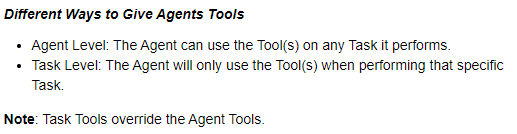

In [15]:
''' by providing the url of the source it will only able to look to this website/source instead of beign diverse in the internet, this is used when you want yout agent to be more specific in what you are looking for'''
docs_scrape_tool = ScrapeWebsiteTool(
    website_url="https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"
)

In [22]:
inquiry_resolution = Task(
    description=(
        "{customer} just reached out with a super important ask:\n"
	    "{inquiry}\n\n"
        "{person} from {customer} is the one that reached out. "
		"Make sure to use everything you know "
        "to provide the best support possible."
		"You must strive to provide a complete "
        "and accurate response to the customer's inquiry."
    ),
    expected_output=(
	    "A detailed, informative response to the "
        "customer's inquiry that addresses "
        "all aspects of their question.\n"
        "The response should include references "
        "to everything you used to find the answer, "
        "including external data or solutions. "
        "Ensure the answer is complete, "
		"leaving no questions unanswered, and maintain a helpful and friendly "
		"tone throughout."
    ),
	tools=[docs_scrape_tool],
    agent=Agent(
        role="Senior Support Representative",
        goal="Be the most friendly and helpful "
            "support representative in your team",
        backstory=(
            "You work at crewAI (https://crewai.com) and "
            " are now working on providing "
            "support to {customer}, a super important customer "
            " for your company."
            "You need to make sure that you provide the best support!"
            "Make sure to provide full complete answers, "
            " and make no assumptions."
        ),
        allow_delegation=False,
        verbose=True,
        llm = AzureChatOpenAI(temperature=.3,
                        azure_endpoint=Endpoint,
                        api_key=APIKey,
                        deployment_name="NA-GenAI-gpt-35-turbo",
                        openai_api_version=version
        )
    )
)

In [23]:
quality_assurance_review = Task(
    description=(
        "Review the response drafted by the Senior Support Representative for {customer}'s inquiry. "
        "Ensure that the answer is comprehensive, accurate, and adheres to the "
		"high-quality standards expected for customer support.\n"
        "Verify that all parts of the customer's inquiry "
        "have been addressed "
		"thoroughly, with a helpful and friendly tone.\n"
        "Check for references and sources used to "
        " find the information, "
		"ensuring the response is well-supported and "
        "leaves no questions unanswered."
    ),
    expected_output=(
        "A final, detailed, and informative response "
        "ready to be sent to the customer.\n"
        "This response should fully address the "
        "customer's inquiry, incorporating all "
		"relevant feedback and improvements.\n"
		"Don't be too formal, we are a chill and cool company "
	    "but maintain a professional and friendly tone throughout."
    ),
    agent=Agent(
            role="Support Quality Assurance Specialist",
            goal="Get recognition for providing the "
            "best support quality assurance in your team",
            backstory=(
                "You work at crewAI (https://crewai.com) and "
                "are now working with your team "
                "on a request from {customer} ensuring that "
                "the support representative is "
                "providing the best support possible.\n"
                "You need to make sure that the support representative "
                "is providing full"
                "complete answers, and make no assumptions."
            ),
            verbose=True,
            llm = AzureChatOpenAI(temperature=.3,
                            azure_endpoint=Endpoint,
                            api_key=APIKey,
                            deployment_name="NA-GenAI-gpt-35-turbo",
                            openai_api_version=version
                            )
        )
     # this is regualar task for QA agent for the quality check of the our above agent response
)


        Setting memory=True when putting the crew together enables Memory.                                                                                                      

In [24]:
'''
        putting together all the tools and agent , the sequeance of the defining order if agents and task are sequeantial, so arragne accordingly
'''
crew = Crew(
  agents=[support_agent, support_quality_assurance_agent],
  tasks=[inquiry_resolution, quality_assurance_review],
  verbose=2,
  memory=True
)

2024-06-17 15:03:33,417 - 15864 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [25]:
inputs = {
    "customer": "DeepLearningAI",
    "person": "Andrew Ng",
    "inquiry": "I need help with setting up a Crew "
               "and kicking it off, specifically "
               "how can I add memory to my crew? "
               "Can you provide guidance?"
}
result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Senior Support Representative
 [INFO]: == Starting Task: DeepLearningAI just reached out with a super important ask:
I need help with setting up a Crew and kicking it off, specifically how can I add memory to my crew? Can you provide guidance?

Andrew Ng from DeepLearningAI is the one that reached out. Make sure to use everything you know to provide the best support possible.You must strive to provide a complete and accurate response to the customer's inquiry.


> Entering new CrewAgentExecutor chain...
I need to provide DeepLearningAI with a detailed and informative response on how to add memory to their Crew and kick it off. I should use the Read website content tool to gather all the necessary information.

Action: Read website content
Action Input: {"url": "https://docs.crewai.com/how-to/Creating-a-Crew-and-kick-it-off/"}
 

Assembling and Activating Your CrewAI Team - crewAI
 Skip to content
 crewAI
 Assembling and Activating Your CrewAI Team
 Initializ

In [27]:
from pprint import pprint
pprint(result)

('Dear DeepLearningAI,\n'
 '\n'
 'Thank you for reaching out to us. To add memory to your Crew, you need to '
 'define your agents with memory capability during the creation process. In '
 'the code example provided on our website, you can see that the Senior '
 'Researcher and Writer agents were created with memory capability by setting '
 'the memory parameter to True. Here is an example of how to create an agent '
 'with memory capability:\n'
 '\n'
 '```\n'
 'from crewai import Agent\n'
 '\n'
 '# Creating an agent with memory capability\n'
 'agent = Agent(\n'
 "    role='My Role',\n"
 "    goal='My Goal',\n"
 '    memory=True,\n'
 "    backstory='My Backstory'\n"
 ')\n'
 '```\n'
 '\n'
 'Once you have defined your agents with memory capability, you can proceed to '
 'form your Crew and kick it off as described on our website. The Crew object '
 'also has a memory parameter that you can set to True to enable memory usage '
 'for the entire Crew.\n'
 '\n'
 'Regarding your inquiry, we h

# CUSTOM TOOLS

In [28]:
from crewai import Agent, Task, Crew

In [49]:
from crewai_tools import DirectoryReadTool, FileReadTool, SerperDevTool

In [50]:
directory_read_tool = DirectoryReadTool(directory='./instructions')
file_read_tool = FileReadTool()
search_tool = SerperDevTool()

In [51]:
from crewai_tools import BaseTool

In [76]:
class SentimentAnalysisTool(BaseTool):
    name: str ="Sentiment Analysis Tool"
    description: str = ("Analyzes the sentiment of text based on user response"
         "to ensure positive and engaging communication."
         "user might give you his insight on the sentiment of text")
    
    def _run(self, text: str) -> str:
        # Your custom code tool goes here
        user_input = input("Enter your text: ")
        
        return "positive"

In [77]:
sentiment_analysis_tool = SentimentAnalysisTool()

In [78]:
lead_profiling_task = Task(
    description=(
        "Conduct an in-depth analysis of {lead_name}, "
        "a company in the {industry} sector "
        "that recently showed interest in our solutions. "
        "Utilize all available data sources "
        "to compile a detailed profile, "
        "focusing on key decision-makers, recent business "
        "developments, and potential needs "
        "that align with our offerings. "
        "This task is crucial for tailoring "
        "our engagement strategy effectively.\n"
        "Don't make assumptions and "
        "only use information you absolutely sure about."
    ),
    expected_output=(
        "A comprehensive report on {lead_name}, "
        "including company background, "
        "key personnel, recent milestones, and identified needs. "
        "Highlight potential areas where "
        "our solutions can provide value, "
        "and suggest personalized engagement strategies."
    ),
    tools=[directory_read_tool, file_read_tool, search_tool],
    agent=Agent(
            role="Sales Representative",
            goal="Identify high-value leads that match "
                "our ideal customer profile",
            backstory=(
                "As a part of the dynamic sales team at CrewAI, "
                "your mission is to scour "
                "the digital landscape for potential leads. "
                "Armed with cutting-edge tools "
                "and a strategic mindset, you analyze data, "
                "trends, and interactions to "
                "unearth opportunities that others might overlook. "
                "Your work is crucial in paving the way "
                "for meaningful engagements and driving the company's growth."
            ),
            allow_delegation=False,
            verbose=True,
            llm = AzureChatOpenAI(temperature=.3,
                            azure_endpoint=Endpoint,
                            api_key=APIKey,
                            deployment_name="NA-GenAI-gpt-35-turbo",
                            openai_api_version=version
            )
        ),
)

In [79]:
personalized_outreach_task = Task(
    description=(
        "Using the insights gathered from "
        "the lead profiling report on {lead_name}, "
        "craft a personalized outreach campaign "
        "aimed at {key_decision_maker}, "
        "the {position} of {lead_name}. "
        "The campaign should address their recent {milestone} "
        "and how our solutions can support their goals. "
        "Your communication must resonate "
        "with {lead_name}'s company culture and values, "
        "demonstrating a deep understanding of "
        "their business and needs.\n"
        "Don't make assumptions and only "
        "use information you absolutely sure about."
    ),
    expected_output=(
        "A series of personalized email drafts "
        "tailored to {lead_name}, "
        "specifically targeting {key_decision_maker}."
        "Each draft should include "
        "a compelling narrative that connects our solutions "
        "with their recent achievements and future goals. "
        "Ensure the tone is engaging, professional, "
        "and aligned with {lead_name}'s corporate identity."
    ),
    tools=[sentiment_analysis_tool, search_tool],
    agent= Agent(
            role="Lead Sales Representative",
            goal="Nurture leads with personalized, compelling communications",
            backstory=(
                "Within the vibrant ecosystem of CrewAI's sales department, "
                "you stand out as the bridge between potential clients "
                "and the solutions they need."
                "By creating engaging, personalized messages, "
                "you not only inform leads about our offerings "
                "but also make them feel seen and heard."
                "Your role is pivotal in converting interest "
                "into action, guiding leads through the journey "
                "from curiosity to commitment."
            ),
            allow_delegation=False,
            verbose=True,
            llm = AzureChatOpenAI(temperature=.3,
                            azure_endpoint=Endpoint,
                            api_key=APIKey,
                            deployment_name="NA-GenAI-gpt-35-turbo",
                            openai_api_version=version)
        ),
)

In [80]:
crew = Crew(
    agents=[
            Agent(
                role="Sales Representative",
                goal="Identify high-value leads that match "
                    "our ideal customer profile",
                backstory=(
                    "As a part of the dynamic sales team at CrewAI, "
                    "your mission is to scour "
                    "the digital landscape for potential leads. "
                    "Armed with cutting-edge tools "
                    "and a strategic mindset, you analyze data, "
                    "trends, and interactions to "
                    "unearth opportunities that others might overlook. "
                    "Your work is crucial in paving the way "
                    "for meaningful engagements and driving the company's growth."
                ),
                allow_delegation=False,
                verbose=True,
                llm = AzureChatOpenAI(temperature=.3,
                                azure_endpoint=Endpoint,
                                api_key=APIKey,
                                deployment_name="NA-GenAI-gpt-35-turbo",
                                openai_api_version=version
                    )
            ), 
            
            Agent(
                role="Lead Sales Representative",
                goal="Nurture leads with personalized, compelling communications",
                backstory=(
                    "Within the vibrant ecosystem of CrewAI's sales department, "
                    "you stand out as the bridge between potential clients "
                    "and the solutions they need."
                    "By creating engaging, personalized messages, "
                    "you not only inform leads about our offerings "
                    "but also make them feel seen and heard."
                    "Your role is pivotal in converting interest "
                    "into action, guiding leads through the journey "
                    "from curiosity to commitment."
                ),
                allow_delegation=False,
                verbose=True,
                llm = AzureChatOpenAI(temperature=.3,
                                azure_endpoint=Endpoint,
                                api_key=APIKey,
                                deployment_name="NA-GenAI-gpt-35-turbo",
                                openai_api_version=version)
            )],
    
    tasks=[lead_profiling_task, 
           personalized_outreach_task],
	
    verbose=2,
	memory=True
)

2024-06-17 15:57:24,039 - 15864 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [81]:
inputs = {
    "lead_name": "DeepLearningAI",
    "industry": "Online Learning Platform",
    "key_decision_maker": "Andrew Ng",
    "position": "CEO",
    "milestone": "product launch"
}

result = crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Sales Representative
 [INFO]: == Starting Task: Conduct an in-depth analysis of DeepLearningAI, a company in the Online Learning Platform sector that recently showed interest in our solutions. Utilize all available data sources to compile a detailed profile, focusing on key decision-makers, recent business developments, and potential needs that align with our offerings. This task is crucial for tailoring our engagement strategy effectively.
Don't make assumptions and only use information you absolutely sure about.


> Entering new CrewAgentExecutor chain...
Thought: I need to gather information on DeepLearningAI to create a comprehensive report. I should start by finding out more about the company's background and recent milestones.

Action: Read a file's content
Action Input: {'file_path': './instructions/DeepLearningAI.txt'}
 

If someone encounters issues while trying to implement or execute the tasks as part of the dynamic sales team at CrewAI, it is cru

In [73]:
pprint(result)

('Email Draft 1:\n'
 '\n'
 'Subject: Congratulations on the Launch of Your New Course!\n'
 '\n'
 'Dear Andrew Ng,\n'
 '\n'
 'I hope this email finds you well. I wanted to reach out to you personally to '
 'congratulate DeepLearningAI on the recent launch of your new course on deep '
 'learning for natural language processing. As a leader in the AI and machine '
 'learning industry, your dedication to providing high-quality training and '
 'education is truly inspiring.\n'
 '\n'
 'At CrewAI, we share your passion for advancing the field of AI and machine '
 'learning. Our solutions can help DeepLearningAI develop and deliver more '
 'advanced courses more efficiently and effectively. We would love the '
 'opportunity to provide you with a customized demo of our platform and offer '
 'a free trial period.\n'
 '\n'
 'Thank you for considering CrewAI as a partner in your mission to educate and '
 'empower the next generation of AI and machine learning experts.\n'
 '\n'
 'Best regards,\n'
 

# AUTOMATE EVENT PLANNING

In [ ]:
from crewai import Agent, Crew, Task

In [5]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

In [7]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [9]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipment"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [11]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [12]:
from pydantic import BaseModel
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

In [13]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",  
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

In [15]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [16]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

In [18]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator, 
            logistics_manager, 
            marketing_communications_agent],
    
    tasks=[venue_task, 
           logistics_task, 
           marketing_task],
    
    verbose=True
)

2024-06-18 09:55:03,676 - 5976 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [20]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

In [ ]:
result = event_management_crew.kickoff(inputs=event_details)

In [23]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

{'address': '747 Howard St, San Francisco, CA 94103',
 'booking_status': 'recommended',
 'capacity': 500,
 'name': 'Moscone Center'}


# Hierarchical Process

In [24]:
from crewai import Agent, Task, Crew

In [25]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

In [26]:
data_analyst_agent = Agent(
    role="Data Analyst",
    goal="Monitor and analyze market data in real-time "
         "to identify trends and predict market movements.",
    backstory="Specializing in financial markets, this agent "
              "uses statistical modeling and machine learning "
              "to provide crucial insights. With a knack for data, "
              "the Data Analyst Agent is the cornerstone for "
              "informing trading decisions.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [27]:
trading_strategy_agent = Agent(
    role="Trading Strategy Developer",
    goal="Develop and test various trading strategies based "
         "on insights from the Data Analyst Agent.",
    backstory="Equipped with a deep understanding of financial "
              "markets and quantitative analysis, this agent "
              "devises and refines trading strategies. It evaluates "
              "the performance of different approaches to determine "
              "the most profitable and risk-averse options.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [28]:
execution_agent = Agent(
    role="Trade Advisor",
    goal="Suggest optimal trade execution strategies "
         "based on approved trading strategies.",
    backstory="This agent specializes in analyzing the timing, price, "
              "and logistical details of potential trades. By evaluating "
              "these factors, it provides well-founded suggestions for "
              "when and how trades should be executed to maximize "
              "efficiency and adherence to strategy.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [29]:
risk_management_agent = Agent(
    role="Risk Advisor",
    goal="Evaluate and provide insights on the risks "
         "associated with potential trading activities.",
    backstory="Armed with a deep understanding of risk assessment models "
              "and market dynamics, this agent scrutinizes the potential "
              "risks of proposed trades. It offers a detailed analysis of "
              "risk exposure and suggests safeguards to ensure that "
              "trading activities align with the firm’s risk tolerance.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [30]:
# Task for Data Analyst Agent: Analyze Market Data
data_analysis_task = Task(
    description=(
        "Continuously monitor and analyze market data for "
        "the selected stock ({stock_selection}). "
        "Use statistical modeling and machine learning to "
        "identify trends and predict market movements."
    ),
    expected_output=(
        "Insights and alerts about significant market "
        "opportunities or threats for {stock_selection}."
    ),
    agent=data_analyst_agent,
)

In [31]:
# Task for Trading Strategy Agent: Develop Trading Strategies
strategy_development_task = Task(
    description=(
        "Develop and refine trading strategies based on "
        "the insights from the Data Analyst and "
        "user-defined risk tolerance ({risk_tolerance}). "
        "Consider trading preferences ({trading_strategy_preference})."
    ),
    expected_output=(
        "A set of potential trading strategies for {stock_selection} "
        "that align with the user's risk tolerance."
    ),
    agent=trading_strategy_agent,
)


In [32]:
# Task for Trade Advisor Agent: Plan Trade Execution
execution_planning_task = Task(
    description=(
        "Analyze approved trading strategies to determine the "
        "best execution methods for {stock_selection}, "
        "considering current market conditions and optimal pricing."
    ),
    expected_output=(
        "Detailed execution plans suggesting how and when to "
        "execute trades for {stock_selection}."
    ),
    agent=execution_agent,
)


In [33]:
# Task for Risk Advisor Agent: Assess Trading Risks
risk_assessment_task = Task(
    description=(
        "Evaluate the risks associated with the proposed trading "
        "strategies and execution plans for {stock_selection}. "
        "Provide a detailed analysis of potential risks "
        "and suggest mitigation strategies."
    ),
    expected_output=(
        "A comprehensive risk analysis report detailing potential "
        "risks and mitigation recommendations for {stock_selection}."
    ),
    agent=risk_management_agent,
)

In [34]:
from crewai import Crew, Process

# Define the crew with agents and tasks
financial_trading_crew = Crew(
    agents=[data_analyst_agent, 
            trading_strategy_agent, 
            execution_agent, 
            risk_management_agent],
    
    tasks=[data_analysis_task, 
           strategy_development_task, 
           execution_planning_task, 
           risk_assessment_task],
    
    manager_llm=AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version),
                    
    process=Process.hierarchical,
    verbose=True
)

2024-06-18 10:26:15,489 - 5976 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [35]:
# Example data for kicking off the process
financial_trading_inputs = {
    'stock_selection': 'BTC',
    'initial_capital': '100000',
    'risk_tolerance': 'Medium',
    'trading_strategy_preference': 'Investement',	
    'news_impact_consideration': True
}

In [36]:
### this execution will take some time to run
result = financial_trading_crew.kickoff(inputs=financial_trading_inputs)

 [DEBUG]: Working Agent: Crew Manager
 [INFO]: Starting Task: Continuously monitor and analyze market data for the selected stock (BTC). Use statistical modeling and machine learning to identify trends and predict market movements.


> Entering new CrewAgentExecutor chain...
I need to delegate tasks to my team members to ensure we can continuously monitor and analyze market data for BTC. 

Action: 
Delegate work to co-worker 

Action Input: 
{
  "coworker": "Data Analyst",
  "task": "Collect and clean market data for BTC",
  "context": "We need to collect and clean market data for BTC to ensure we have accurate data to analyze."
}


> Entering new CrewAgentExecutor chain...
I need to find a reliable source for market data on BTC.

Action: Read website content

Action Input: {'website_url': 'https://www.coindesk.com/price/bitcoin'}
 

Bitcoin Price | BTC Price Index and Live Chart - CoinDesk
Search CoinDeskPriceIndicesCoinDesk 20CESR™ Composite Ether Staking RateBitcoin Trend IndicatorE

In [38]:
pprint(result)

('Risk Analysis Report for BTC Trading Strategies and Execution Plans\n'
 '\n'
 'Introduction:\n'
 'The purpose of this report is to analyze the risks associated with the '
 'proposed trading strategies and execution plans for BTC and provide detailed '
 'recommendations for mitigating these risks.\n'
 '\n'
 'Risks:\n'
 'After analyzing the Investopedia article on how to buy Bitcoin, it is clear '
 'that there are several risks associated with trading Bitcoin. One of the '
 'main risks is the potential for theft or hacking of Bitcoin wallets or '
 'exchanges, which can result in the loss of funds. Another risk is the '
 'volatility of Bitcoin prices, which can lead to significant losses if the '
 'market suddenly drops. Additionally, there is the risk of regulatory changes '
 'or government intervention that could impact the value of Bitcoin.\n'
 '\n'
 'Mitigation Strategies:\n'
 'To mitigate the risks associated with BTC trading, it is important to '
 'implement the following strategi

# JON APPLICATION

In [4]:
from crewai import Agent, Task, Crew

In [6]:
from crewai_tools import (
  FileReadTool,
  ScrapeWebsiteTool,
  MDXSearchTool,
  SerperDevTool
)

search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()
read_resume = FileReadTool(file_path='./fake_resume.md')
# semantic_search_resume = MDXSearchTool(mdx='./fake_resume.md') # this can used for the semantic search of resume with the posting

In [8]:
# Agent 1: Researcher
researcher = Agent(
    role="Tech Job Researcher",
    goal="Make sure to do amazing analysis on "
         "job posting to help job applicants",
    tools = [scrape_tool, search_tool],
    verbose=True,
    backstory=(
        "As a Job Researcher, your prowess in "
        "navigating and extracting critical "
        "information from job postings is unmatched."
        "Your skills help pinpoint the necessary "
        "qualifications and skills sought "
        "by employers, forming the foundation for "
        "effective application tailoring."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [10]:
# Agent 2: Profiler
profiler = Agent(
    role="Personal Profiler for Engineers",
    goal="Do increditble research on job applicants "
         "to help them stand out in the job market",
    tools = [scrape_tool, search_tool,
             read_resume], #semantic_search_resume can be added
    verbose=True,
    backstory=(
        "Equipped with analytical prowess, you dissect "
        "and synthesize information "
        "from diverse sources to craft comprehensive "
        "personal and professional profiles, laying the "
        "groundwork for personalized resume enhancements."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [12]:
# Agent 3: Resume Strategist
resume_strategist = Agent(
    role="Resume Strategist for Engineers",
    goal="Find all the best ways to make a "
         "resume stand out in the job market.",
    tools = [scrape_tool, search_tool,
             read_resume],  #semantic_search_resume can be added
    verbose=True,
    backstory=(
        "With a strategic mind and an eye for detail, you "
        "excel at refining resumes to highlight the most "
        "relevant skills and experiences, ensuring they "
        "resonate perfectly with the job's requirements."
    ),
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [13]:
# Agent 4: Interview Preparer
interview_preparer = Agent(
    role="Engineering Interview Preparer",
    goal="Create interview questions and talking points "
         "based on the resume and job requirements",
    tools = [scrape_tool, search_tool,
             read_resume], # semantic_search_resume also
    verbose=True,
    backstory=(
        "Your role is crucial in anticipating the dynamics of "
        "interviews. With your ability to formulate key questions "
        "and talking points, you prepare candidates for success, "
        "ensuring they can confidently address all aspects of the "
        "job they are applying for."
    ),
     llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [15]:
# Task for Researcher Agent: Extract Job Requirements
research_task = Task(
    description=(
        "Analyze the job posting URL provided ({job_posting_url}) "
        "to extract key skills, experiences, and qualifications "
        "required. Use the tools to gather content and identify "
        "and categorize the requirements."
    ),
    expected_output=(
        "A structured list of job requirements, including necessary "
        "skills, qualifications, and experiences."
    ),
    agent=researcher,
    async_execution=True # here async means it will be used parallely with other tasks without blocking 
)

In [16]:
# Task for Profiler Agent: Compile Comprehensive Profile
profile_task = Task(
    description=(
        "Compile a detailed personal and professional profile "
        "using the GitHub ({github_url}) URLs, and personal write-up "
        "({personal_writeup}). Utilize tools to extract and "
        "synthesize information from these sources."
    ),
    expected_output=(
        "A comprehensive profile document that includes skills, "
        "project experiences, contributions, interests, and "
        "communication style."
    ),
    agent=profiler,
    async_execution=True
)

In [17]:
# Task for Resume Strategist Agent: Align Resume with Job Requirements
resume_strategy_task = Task(
    description=(
        "Using the profile and job requirements obtained from "
        "previous tasks, tailor the resume to highlight the most "
        "relevant areas. Employ tools to adjust and enhance the "
        "resume content. Make sure this is the best resume even but "
        "don't make up any information. Update every section, "
        "inlcuding the initial summary, work experience, skills, "
        "and education. All to better reflrect the candidates "
        "abilities and how it matches the job posting."
    ),
    expected_output=(
        "An updated resume that effectively highlights the candidate's "
        "qualifications and experiences relevant to the job."
    ),
    output_file="tailored_resume.md",
    context=[research_task, profile_task],
    agent=resume_strategist
)

In [18]:
# Task for Interview Preparer Agent: Develop Interview Materials
interview_preparation_task = Task(
    description=(
        "Create a set of potential interview questions and talking "
        "points based on the tailored resume and job requirements. "
        "Utilize tools to generate relevant questions and discussion "
        "points. Make sure to use these question and talking points to "
        "help the candiadte highlight the main points of the resume "
        "and how it matches the job posting."
    ),
    expected_output=(
        "A document containing key questions and talking points "
        "that the candidate should prepare for the initial interview."
    ),
    output_file="interview_materials.md",
    context=[research_task, profile_task, resume_strategy_task],
    agent=interview_preparer
)


In [19]:
job_application_crew = Crew(
    agents=[researcher,
            profiler,
            resume_strategist,
            interview_preparer],

    tasks=[research_task,
           profile_task,
           resume_strategy_task,
           interview_preparation_task],

    verbose=True
)

In [20]:
job_application_inputs = {
    'job_posting_url': 'https://jobs.lever.co/AIFund/6c82e23e-d954-4dd8-a734-c0c2c5ee00f1?lever-origin=applied&lever-source%5B%5D=AI+Fund',
    'github_url': 'https://github.com/joaomdmoura',
    'personal_writeup': """Noah is an accomplished Software
    Engineering Leader with 18 years of experience, specializing in
    managing remote and in-office teams, and expert in multiple
    programming languages and frameworks. He holds an MBA and a strong
    background in AI and data science. Noah has successfully led
    major tech initiatives and startups, proving his ability to drive
    innovation and growth in the tech industry. Ideal for leadership
    roles that require a strategic and innovative approach."""
}

In [ ]:
### this execution will take a few minutes to run
result = job_application_crew.kickoff(inputs=job_application_inputs)

# FOR RooCA and IKON

In [1]:
import base64,os
import configparser
from typing import List
from langchain.prompts import PromptTemplate
from langchain_openai import AzureChatOpenAI
from langchain.llms.openai import AzureOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain_core.runnables import RunnableLambda, RunnableParallel
from langchain.output_parsers import RetryOutputParser,RetryWithErrorOutputParser
from langchain_community.embeddings import BedrockEmbeddings
from langchain_community.llms.bedrock import Bedrock
from langchain_community.vectorstores.faiss import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models.bedrock import BedrockChat
# from langchain_community.chat_models.azure_openai import AzureChatOpenAI
# from langchain.chat_models import AzureChatOpenAI



config = configparser.ConfigParser()
config.read('config.properties')

APIKey = config['AzureCredentials']['APIKey']
APIKey=base64.b64decode(APIKey).decode('utf-8')
Endpoint = config['AzureCredentials']['Endpoint']
Deployment = config['AzureCredentials']['Deployment']
version = config['AzureCredentials']['version']
EmbeddingDeployment = config['AzureCredentials']['EmbeddingDeployment']
os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2023-05-15"
os.environ["azure_endpoint"] = Endpoint
os.environ["AZURE_OPENAI_API_KEY"] = APIKey


In [2]:
from DatabaseFunctions import DatabaseFunctions

# config.read(f'./config/WB/ConfigFile.properties')
# host = config.get('DatabaseSection','database.host')
# port = config.get('DatabaseSection','database.port')
# username = config.get('DatabaseSection','database.user')
# password = config.get('DatabaseSection','database.password')
# database = config.get('DatabaseSection','database.dbname')
# schema = config.get('DatabaseSection','database.schema')
# config.read(f'./config/WB/ConfigFile.properties')
host = "INBLRAMSTooldev"
port = "5432"
username = "ikon_dev"
password = "ikon_dev@123"
database = "IKON"
schema = "generic_ko_test"
psql = DatabaseFunctions(host,username,password,port,database,schema)

'DatabaseSection'


In [3]:
from sentence_transformers import SentenceTransformer

c:\Users\SIVERMA\Documents\Experimenting\AGENT\AGENTS\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [5]:
embed = SentenceTransformer(r"C:\Users\SIVERMA\Documents\Experimenting\GENERIC_KO_API\paraphrase-multilingual-MiniLM-L12-v2")

In [6]:
def get_embeddings(texts) :
    return embed.encode(texts)
len(get_embeddings("helo"))

384

In [7]:
df = psql.select_df("ko_detail_history_mongo")

'DatabaseFunctions' object has no attribute 'sql_type'
'DatabaseFunctions' object has no attribute 'metadata'
'DatabaseFunctions' object has no attribute 'connection'


In [64]:
df[~df['EMBED'].isna()]

,Ko_id,Ticket_group,App_name,Ko_status,Publication_status,Summary,Ko_text,Module_name,Bpl_id,EMBED


In [59]:
df["EMBED"] = df["Ko_text"].iloc[:20].apply(lambda x : get_embeddings(x))

In [73]:
# df20['EMBED'] =20 #df[~df['EMBED'].isna()]
psql = DatabaseFunctions(host,username,password,port,database,schema,config)
psql.upsert_df(df,"ko_detail_history_mongo")

DatabaseSection is in config
==============  sql_type  ==============:  1
AuditFlag not present in config
Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)


In [ ]:
df

,Ko_id,Ticket_group,App_name,Ko_status,Publication_status,Summary,Ko_text,Module_name,Bpl_id,EMBED
0,GS10551,,Order To Cash - SAP SD,1,Published,Issue with Stock in MD04 and CO09(Inconsisten...,Issue with Stock in MD04 and CO09(Inconsisten...,None,339,20
1,GS10552,,Order To Cash - SAP SD,1,Published,We had received an issue for one Media custom...,We had received an issue for one Media custom...,None,340,20
2,GS10553,,Order To Cash - SAP SD,1,Published,Picking Status not updated in VBUP Table Not ...,Picking Status not updated in VBUP Table Not ...,None,341,20
3,GS10003,,,1,Published,LiveCache Database connection,LiveCache Database connection Starting liveCac...,Basis,292,20
4,GS10005,,,1,Published,Inconsistency in tables TBTCO and TBTCP,Inconsistency in tables TBTCO and TBTCP We get...,Basis,292,20
5,GS10006,,,1,Published,Job fail e-mail alerts and restart limit in Re...,Job fail e-mail alerts and restart limit in Re...,Basis,292,20
6,GS10007,,,1,Published,Job migration from SAP to Redwood,Job migration from SAP to Redwood Job migratio...,Basis,292,20
7,GS10051,,,1,Published,Delta TRs missing post refresh,Delta TRs missing post refresh After refresh t...,Basis,292,20
8,GS10074,,,1,Published,Process STO Return Serial Profile Quantity Off...,Process STO Return Serial Profile Quantity Off...,Supply Chain - SAP PP,165,20
9,GS10554,,Order To Cash - SAP SD,1,Published,Delivery Processing Failed via SHPCON IDOC an...,Delivery Processing Failed via SHPCON IDOC an...,None,342,20


In [33]:
df = psql.select_df("ticket_data_staging_mongo")
df.rename(columns={'Incident_id':'incident_id',
        'Assigned_Group':'assigned_group',
        'App_Name':"app_name",
        'Status':"status",
        'Summary':"summary",
        'Inc_text':"inc_text"},inplace=True)

psql.upsert_df(df.iloc[:20],"ticket_data_inter_mongo")

In [34]:
df.columns

Index(['incident_id', 'assigned_group', 'app_name', 'status', 'summary',
       'inc_text'],
      dtype='object')

In [20]:
from langchain.output_parsers import PydanticOutputParser
from langchain_core.runnables import RunnableLambda, RunnableParallel
from langchain_core.pydantic_v1 import BaseModel as lbasemodel
from langchain_core.pydantic_v1 import Field 


class _Config(lbasemodel):
    account:str=Field(alias="Account name for which query is asked")
    ticket_inquery:str=Field(alias="for which tikets status is nedded ,convert to folowing values : 'Assigned', 'In Progress', 'Pending', 'Resolved' or 'Closed'")
    database:str=Field(alias="Database name if given otherwies None")
    host:str=Field(alias="Host if given otherwies None")
    port:str=Field(alias="Port if given otherwies None")
    username:str=Field(alias="Username if given otherwies None")
    password:str=Field(alias="Password if given otherwies None")
    _schema:str=Field(alias="Schema if given otherwies None")
    no_of_tickets:str = Field(alias="number of ticket if user has asked to instert else 0")
    
def _format_the_userinput(query:str):
    template = "you are an output formatter for user query {query} into _Config class object,respond only with one {format_instructions} object of _Config class:"
    parser = PydanticOutputParser(pydantic_object=_Config)
    llm = AzureChatOpenAI(temperature=.3,
                        azure_endpoint=Endpoint,
                        api_key=APIKey,
                        deployment_name="NA-GenAI-gpt-35-turbo",
                        openai_api_version=version
                        )
    retry_parser = RetryWithErrorOutputParser.from_llm(parser=parser, llm=llm,max_retries=1)
    prompt = PromptTemplate(
        template=template,
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    completion_chain = prompt | llm

    main_chain = RunnableParallel(completion=completion_chain, prompt_value=prompt) | RunnableLambda(lambda x: retry_parser.parse_with_prompt(x['completion'].content,x['prompt_value']))
    while trie >=5:
        try:
            return main_chain.invoke({"query":query})
        except:
            trues-=1
    
    return main_chain.invoke({"query":query})

In [21]:
from crewai_tools import BaseTool
import configparser
from crewai import Agent, Task, Crew, Process
import matplotlib.pyplot as plt
from DatabaseFunctions import DatabaseFunctions


class StatusQueryTool(BaseTool):
    
    name: str = "DatabaseQueryTool"
    description: str = "Tool to query the database for ticket status."

    def _run(self, query: str) -> str:
        config = configparser.ConfigParser()
        _formated = _format_the_userinput(query)
        Account_name = _formated.account
        status_type = _formated.ticket_inquery
        
        if status_type.lower() in ['inprogress', 'in progress']:
            status_type = 'In Progress'
        elif status_type.lower() in ['assigned']:
            status_type = 'Assigned'
        elif status_type.lower() in ['pending']:
            status_type = 'Pending'
        else:
            status_type = 'Resolved'

        config.read(f'./config/{Account_name}/ConfigFile.properties')
        host = config.get('DatabaseSection','database.host')
        port = config.get('DatabaseSection','database.port')
        username = config.get('DatabaseSection','database.user')
        password = config.get('DatabaseSection','database.password')
        database = config.get('DatabaseSection','database.dbname')
        schema = config.get('DatabaseSection','database.schema')
        psql = DatabaseFunctions(host,username,password,port,database,schema,config)

        try:
            # ___________________________________________________________ reading status
            df = psql.select_df("ticket_data_inter_mongo")
            if len(df)>0:
                print("inside the database query","\n\n\n",df.shape)
                Assigned = df[df['status'] == 'Assigned'].shape[0]
                # Closed = df[df['status'] == 'Closed'].shape[0]
                In_Progress = df[df['status'] == 'In Progress'].shape[0]
                Pending = df[df['status'] == 'Pending'].shape[0]
                Resolved = df[df['status'] == 'Resolved'].shape[0]
                
            
                # __________________________________________________________ plot
                labels=["Assigned", "In Progress", "Pending", "Resolved"]
                explode = tuple([0.1 if i == status_type else 0 for i in  labels])
                print(explode,"************")
                fig, ax = plt.subplots()
                wedges, texts, autotexts = ax.pie([Assigned, In_Progress, Pending, Resolved],explode = explode, labels=["Assigned", "In Progress", "Pending", "Resolved"], 
                                                autopct='%1.1f%%', startangle=140)
                plt.title(f'Ticket Status for account {Account_name}')

                total = sum([Assigned, In_Progress, Pending, Resolved])
                legend_labels = [f'{label}: {size} ({size/total:.1%})' for label, size in zip(["Assigned", "In Progress", "Pending", "Resolved"],[Assigned, In_Progress, Pending, Resolved])]
                plt.legend(wedges, legend_labels, title="Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, .5))
                plt.savefig('pie_chart.png')

                if In_Progress > 0:
                    ticket_status = f"there are {status_type} tickets In Progress"
                else:
                    ticket_status = "All tickets are resolved"

                return f"ticket status for account {Account_name} is {ticket_status}"

            else:
                return f"no tickets found for account {Account_name}"
        except Exception as e:
            return f"there was a problem querying the database: {e}"



In [8]:
database_query_tool = StatusQueryTool()

specialized_agent = Agent(
    role='Ticket status checker',
    goal='Handle ticket-related queries and provide status updates or insert tickets.',
    verbose=True,
    memory=True,
    backstory=(
        "You are an expert in managing and resolving ticket-related inquiries, "
        "providing users with accurate and timely updates on their ticket status."
        "you will be given a query for an accoutn and you will be expected to respond with status of tickets for that acount"
    ),
    tools=[database_query_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

In [9]:

class _insertConfig(lbasemodel):
    account:str=Field(alias="Account name for which query is asked")
    no_of_tickets:str = Field(alias="number of ticket if user has asked to instert else 0")
    
def _insert_format_the_userinput(query:str):
    template = "you are an output formatter for user query {query} into _Config class object,respond only with one {format_instructions} object of _Config class:"
    parser = PydanticOutputParser(pydantic_object=_insertConfig)
    llm = AzureChatOpenAI(temperature=.3,
                        azure_endpoint=Endpoint,
                        api_key=APIKey,
                        deployment_name="NA-GenAI-gpt-35-turbo",
                        openai_api_version=version
                        )
    retry_parser = RetryWithErrorOutputParser.from_llm(parser=parser, llm=llm,max_retries=1)
    prompt = PromptTemplate(
        template=template,
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    completion_chain = prompt | llm

    main_chain = RunnableParallel(completion=completion_chain, prompt_value=prompt) | RunnableLambda(lambda x: retry_parser.parse_with_prompt(x['completion'].content,x['prompt_value']))
    return main_chain.invoke({"query":query})


class InsertDatabaseQueryTool(BaseTool):
    
    name: str = "InsertDatabaseQueryTool"
    description: str = "Tool to insert tickets in database."

    def _run(self, query: str) -> str:
        config = configparser.ConfigParser()
        _formated = _insert_format_the_userinput(query)
        
        Account_name = _formated.account
        print(query)
        no_of_tickets = min(int(_formated.no_of_tickets),20)
        print(no_of_tickets,"*******************")
        exit()
        config.read(f'./config/{Account_name}/ConfigFile.properties')
        host = config.get('DatabaseSection','database.host')
        port = config.get('DatabaseSection','database.port')
        username = config.get('DatabaseSection','database.user')
        password = config.get('DatabaseSection','database.password')
        database = config.get('DatabaseSection','database.dbname')
        schema = config.get('DatabaseSection','database.schema')
        psql = DatabaseFunctions(host,username,password,port,database,schema,config)

        try:
            # ___________________________________________________________ reading status
            df = psql.select_df("ticket_data_staging_mongo")
            psql.upsert_df(df.iloc[:no_of_tickets],"ticket_data_inter_mongo")
            
        except Exception as e:
            return f"there was a problem querying the database: {e}"


In [10]:
insert_tool = InsertDatabaseQueryTool()

# specialized_agent_insert = Agent(
#     role='Ticket status checker',
#     goal='insert the tickets in database for account if user askes, in the database when a user inquires about it. ',
#     verbose=True,
#     memory=True,
#     backstory=(
#         "You are an expert in inserting ticket-related inquiries, "
#         "you will be given a query for an accoutnt and you will be expected to insert few tickets in the database for that account"
#     ),
#     tools=[insert_tool],
#     llm = AzureChatOpenAI(temperature=.3,
#                     azure_endpoint=Endpoint,
#                     api_key=APIKey,
#                     deployment_name="NA-GenAI-gpt-35-turbo",
#                     openai_api_version=version
#     )
# )
specialized_agent_insert = Agent(
    role='Ticket Insertion Specialist',
    goal='Handle ticket insertion into the database based on user requests.',
    verbose=True,
    memory=True,
    backstory=(
        "You are an expert in managing and inserting ticket data into the database, "
        "ensuring accurate and timely updates based on user requests."
    ),
    tools=[insert_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)


In [11]:
from crewai import Agent, Task, Crew

chatbot_agent = Agent(
    role='Customer Support Chatbot',
    goal='Assist users with their queries and provide relevant information.',
    verbose=True,
    memory=True,
    backstory=(
        "You are a friendly and helpful chatbot designed to assist users with "
        "their questions and provide information or execute specific tasks as needed."
    ),
    allow_delegation=True,
    llm=AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)


In [12]:
check_ticket_status_task = Task(
    description=(
        "Check the status of a tickets for following query: ({query}) in the database when a user inquires about it. "
        "return the status of the tickets only nothing else."
    ),
    expected_output='The current status of the tickets under given account.',
    tools=[database_query_tool],
    agent=specialized_agent
)

In [13]:
insert_into_database = Task(
    description=(
        "insert few tickets to the database for account if user askes,user has given following account details: ({query}) ,insert tickets in the database when a user inquires about it. "
    ),
    expected_output='on the basis of response , return inserted or failed',
    tools=[insert_tool],
    agent=specialized_agent_insert
)

In [48]:

class _insertConfig(lbasemodel):
    account:str=Field(alias="Account name for which query is asked")
    
def _insert_format_the_userinput(query:str) -> _insertConfig:
    template = "you are an output formatter for user query {query} into _Config class object,respond only with one {format_instructions} object of _Config class:"
    parser = PydanticOutputParser(pydantic_object=_insertConfig)
    llm = AzureChatOpenAI(temperature=.3,
                        azure_endpoint=Endpoint,
                        api_key=APIKey,
                        deployment_name="NA-GenAI-gpt-35-turbo",
                        openai_api_version=version
                        )
    retry_parser = RetryWithErrorOutputParser.from_llm(parser=parser, llm=llm,max_retries=1)
    prompt = PromptTemplate(
        template=template,
        input_variables=["query"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    completion_chain = prompt | llm

    main_chain = RunnableParallel(completion=completion_chain, prompt_value=prompt) | RunnableLambda(lambda x: retry_parser.parse_with_prompt(x['completion'].content,x['prompt_value']))
    return main_chain.invoke({"query":query})


class InsertDatabaseQueryTool(BaseTool):
    
    name: str = "InsertDatabaseQueryTool"
    description: str = "Tool to insert tickets in database."

    def _run(self, account: str) -> str:
        config = configparser.ConfigParser()
        _formated = _insert_format_the_userinput(account)
        Account_name = _formated.account
        config.read(f'./config/{Account_name}/ConfigFile.properties')
        host = config.get('DatabaseSection','database.host')
        port = config.get('DatabaseSection','database.port')
        username = config.get('DatabaseSection','database.user')
        password = config.get('DatabaseSection','database.password')
        database = config.get('DatabaseSection','database.dbname')
        schema = config.get('DatabaseSection','database.schema')
        psql = DatabaseFunctions(host,username,password,port,database,schema,config)

        try:
            # ___________________________________________________________ reading status
            df = psql.select_df("ticket_data_staging_mongo")
            df.rename(columns={'Incident_id':'incident_id',
                                'Assigned_Group':'assigned_group',
                                'App_Name':"app_name",
                                'Status':"status",
                                'Summary':"summary",
                                'Inc_text':"inc_text"},inplace=True)
            
            psql.upsert_df(df.iloc[:40],"ticket_data_inter_mongo")
        except Exception as e:
            return f"there was a problem querying the database: {e}"
        
        return "20 tickects inserted successfully"

insert_tool = InsertDatabaseQueryTool()


specialized_agent_insert = Agent(
    role='Ticket Insertion Specialist',
    goal='Handle ticket insertion into the database based on user requests.',
    verbose=True,
    memory=True,
    backstory=(
        "You are an expert in managing and inserting ticket data into the database, "
        "ensuring accurate and timely updates based on user requests."
    ),
    tools=[insert_tool],
    llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)



insert_into_database = Task(
    description=(
        "insert few tickets to the database for account if user askes,user has given following query: ({query}) ,insert tickets in the database when a user inquires about it. "
    ),
    expected_output='on the basis of response , return inserted or failed',
    tools=[insert_tool],
    agent=specialized_agent_insert
)

crew = Crew(
    agents=[specialized_agent_insert],
    tasks=[ insert_into_database],
    process=Process.hierarchical,  # Task execution process can be customized,
    manager_llm = AzureChatOpenAI(temperature=.3,
                    azure_endpoint=Endpoint,
                    api_key=APIKey,
                    deployment_name="NA-GenAI-gpt-35-turbo",
                    openai_api_version=version
    )
)

2024-06-18 18:54:50,599 - 25492 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed


In [49]:
output = crew.kickoff({"query": "insert 20 tickets for 'WB' account'"})
# output = crew.kickoff({"query": "is their Inprogress tickets for the account 'WB' "})



> Entering new CrewAgentExecutor chain...
I need to delegate the task of inserting tickets to the Ticket Insertion Specialist.

Action: 
Delegate work to co-worker

Action Input: 
{
  "coworker": "Ticket Insertion Specialist",
  "task": "Insert 20 tickets for 'WB' account",
  "context": "Here is the query from the user: (insert 20 tickets for 'WB' account')"
}


> Entering new CrewAgentExecutor chain...
I need to use the InsertDatabaseQueryTool to insert 20 tickets for the 'WB' account.

Action: 
InsertDatabaseQueryTool

Action Input: 
{"account": "WB", "tickets": 20}
DatabaseSection is in config
==============  sql_type  ==============:  1
AuditFlag not present in config
 

20 tickects inserted successfully

Final Answer: 
To insert 20 tickets for the 'WB' account, I used the InsertDatabaseQueryTool with the following input: {"account": "WB", "tickets": 20}. The observation was that 20 tickets were inserted successfully.

> Finished chain.
 

To insert 20 tickets for the 'WB' accoun

In [50]:
psql.select_df("ticket_data_inter_mongo").shape

(4040, 6)